In [79]:
import matplotlib.pyplot as plt
import dynet as dy
import re

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)

### Подготовка данных
Тут мы находим параметры для сетки (максимальную длину строки и размер вокаб\_сайза) и разбиваем датасет на трейн и тест.

In [80]:
def find_params(X_corpus, y_corpus):
    max_length = 0
    morph = []
    syntax = []
    
    for i in range(len(X_corpus)):
        morph += X_corpus[i].split()
        syntax += y_corpus[i].split()
        
        if len(X_corpus[i].split()) > max_length:
            max_length = len(X_corpus[i].split())
            
    morph = list(set(morph))
    syntax = list(set(syntax))
    
    return max_length, morph, syntax

In [81]:
def train_test_split(X_corpus, y_corpus): #train/test = 80/10        
    train_ind = round(len(X_corpus) * 0.8)
    train_set = []
    test_set = []
    
    for i in range(train_ind):
        train_set.append((X_corpus[i].strip(' \n'), y_corpus[i].strip(' \n')))
    
    for i in range(train_ind, len(X_corpus)):
        test_set.append((X_corpus[i].strip(' \n'), y_corpus[i].strip(' \n')))
    
    return train_set, test_set

In [82]:
def prepare_data(X_filename, y_filename):
    EOS = "<EOS>"

    with open(X_filename, 'r', encoding = 'utf-8') as file:
        X_corpus = file.readlines()

    with open(y_filename, 'r', encoding = 'utf-8') as file:
        y_corpus = file.readlines()

    train_set, test_set = train_test_split(X_corpus, y_corpus)
    max_length, morph, syntax = find_params(X_corpus, y_corpus)

    morph.append(EOS)
    syntax.append(EOS)

    morph2int = {c:i for i,c in enumerate(morph)}
    syntax2int = {c:i for i,c in enumerate(syntax)}
    int2syntax = {i:c for i,c in enumerate(syntax)}
    
    voc_size = len(morph) + len(syntax)
    
    return train_set, test_set, morph2int, syntax2int, int2syntax, max_length, voc_size

### Тренировка и оценка косяков
Вот эта штука тренирует модель и рисует график потерь.

Как это происходит:
* Размер обучающей выборки увеличивается в epochs раз
* Для каждой пары считается потеря и передается тренеру, тренер обновляется
* Если номер пары кратен изначальному размеру сета (по факту, прошло обучение на одном сете, одна итерация), считается сумма потерь на тестовой выборке

Что нам мешает нарисовать такой же график для accuracy_score?

In [83]:
def train(network, train_set, test_set, num_of_iter = 50):
    def get_val_set_loss(network, test_set):
        loss = [network.get_loss(input_string, output_string).value() for input_string, output_string in test_set]
        return sum(loss)
    
    train_set = train_set*num_of_iter
    trainer = dy.SimpleSGDTrainer(network.model)
    losses = []
    iterations = []
    scores = []
    
    for i, training_example in enumerate(train_set):
        input_string, output_string = training_example
        
        loss = network.get_loss(input_string, output_string)
        loss_value = loss.value()

        loss.backward()
        trainer.update()

        if i%(len(train_set)/num_of_iter) == 0:
            test_loss = get_val_set_loss(network, test_set)
            test_score = get_accuracy_score(network, test_set)
            train_result = network.generate(train_set[0][0])
            test_result = network.generate(test_set[0][0])
            
            iterations.append(i/(len(train_set)/num_of_iter))
            losses.append(test_loss)
            scores.append(test_score)

    plt.plot(iterations, losses)
    plt.axis([0, 50, 0, (sum(losses)/len(losses)*2)])
    plt.show() 
    print('final loss on test set:', test_loss)
    
    plt.plot(iterations, scores)
    plt.axis([0, 50, 0, (sum(scores)/len(scores)*2)])
    plt.show() 
    print('final accuracy on test set:', test_score)

In [84]:
def get_accuracy_score(network, test_set):
    errors = []

    for i in range (len(test_set)):
        c = 0
        pred_answer = network.generate(test_set[i][0]).split()
        true_answer = test_set[i][1].split()
        
        if len(true_answer) == len(pred_answer):
            for j in range (len(true_answer)):
                if pred_answer[j] == true_answer[j]:
                    c += 1
        errors.append(c / len(true_answer))

    accuracy_score = sum(errors) / len(errors)
    
    return accuracy_score

### SimpleRNNNetwork
На основе вот этой вот штуки будет построена Seq2Seq модель

In [85]:
class SimpleRNNNetwork:
    def __init__(self, rnn_num_of_layers, embeddings_size, state_size):
        self.model = dy.Model()
        self.embeddings = self.model.add_lookup_parameters((VOCAB_SIZE, embeddings_size))
        self.RNN = RNN_BUILDER(rnn_num_of_layers, embeddings_size, state_size, self.model)
        self.output_w = self.model.add_parameters((VOCAB_SIZE, state_size))
        self.output_b = self.model.add_parameters((VOCAB_SIZE))
    
    def _preprocess_input(self, string):
        string = string.split() + [EOS]
        return [morph2int[c] for c in string]
    
    def _preprocess_output(self, string):
        string = string.split() + [EOS]
        return [syntax2int[c] for c in string]
    
    def _embed_string(self, string):
    	return [self.embeddings[word] for word in string]

    def _run_rnn(self, init_state, input_vecs):
        s = init_state
        states = s.add_inputs(input_vecs)
        rnn_outputs = [s.output() for s in states]
        
        return rnn_outputs
    
    def _get_probs(self, rnn_output):
        output_w = dy.parameter(self.output_w)
        output_b = dy.parameter(self.output_b)
        probs = dy.softmax(output_w * rnn_output + output_b)
        
        return probs

    def get_loss(self, input_string, output_string):
        input_string = self._preprocess_input(input_string)
        output_string = self._preprocess_output(output_string)

        dy.renew_cg()

        embedded_string = self._embed_string(input_string)
        
        rnn_state = self.RNN.initial_state()
        rnn_outputs = self._run_rnn(rnn_state, embedded_string)
        loss = []

        for rnn_output, output_tag in zip(rnn_outputs, output_string):
            probs = self._get_probs(rnn_output)
            loss.append(-dy.log(dy.pick(probs, output_tag)))
        
        loss = dy.esum(loss)
        
        return loss

    def _predict(self, probs):
        probs = probs.value()
        predicted_tag = int2syntax[probs.index(max(probs))]
        
        return predicted_tag
    
    def generate(self, input_string):
        input_string = self._preprocess_input(input_string)

        dy.renew_cg()

        embedded_string = self._embed_string(input_string)
        rnn_state = self.RNN.initial_state()
        rnn_outputs = self._run_rnn(rnn_state, embedded_string)
        
        output_string = []
        
        for rnn_output in rnn_outputs:
            probs = self._get_probs(rnn_output)
            predicted_tag = self._predict(probs)
            output_string.append(predicted_tag)
        
        output_string = ' '.join(output_string)
        
        return output_string.replace('<EOS>', '')

In [86]:
class AttentionNetwork:
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        self.model = dy.Model()
        self.embeddings = self.model.add_lookup_parameters((VOCAB_SIZE, embeddings_size))

        self.ENC_RNN = RNN_BUILDER(enc_layers, embeddings_size, enc_state_size, self.model)
        self.DEC_RNN = RNN_BUILDER(dec_layers, enc_state_size, dec_state_size, self.model)

        self.output_w = self.model.add_parameters((VOCAB_SIZE, dec_state_size))
        self.output_b = self.model.add_parameters((VOCAB_SIZE))

        self.attention_w1 = self.model.add_parameters((enc_state_size, enc_state_size))
        self.attention_w2 = self.model.add_parameters((enc_state_size, dec_state_size))
        self.attention_v = self.model.add_parameters((1, enc_state_size))

        self.enc_state_size = enc_state_size

    def _preprocess_input(self, string):
        string = string.split() + [EOS]
        return [morph2int[c] for c in string]
    
    def _preprocess_output(self, string):
        string = string.split() + [EOS]
        return [syntax2int[c] for c in string]
    
    def _embed_string(self, string):
        return [self.embeddings[word] for word in string]

    def _encode_string(self, embedded_string):
        initial_state = self.ENC_RNN.initial_state()
        hidden_states = self._run_rnn(initial_state, embedded_string)

        return hidden_states

    def _attend(self, input_vectors, state):
        w1 = dy.parameter(self.attention_w1)
        w2 = dy.parameter(self.attention_w2)
        v = dy.parameter(self.attention_v)
        
        attention_weights = []
        w2dt = w2 * state.h()[-1]

        for input_vector in input_vectors:
            attention_weight = v * dy.tanh(w1 * input_vector + w2dt)
            attention_weights.append(attention_weight)
        
        attention_weights = dy.softmax(dy.concatenate(attention_weights))
        output_vectors = dy.esum([vector * attention_weight for vector, attention_weight in zip(input_vectors, attention_weights)])
        
        return output_vectors

    def _run_rnn(self, init_state, input_vecs):
        s = init_state
        states = s.add_inputs(input_vecs)
        rnn_outputs = [s.output() for s in states]
        
        return rnn_outputs
    
    def _get_probs(self, rnn_output):
        output_w = dy.parameter(self.output_w)
        output_b = dy.parameter(self.output_b)
        probs = dy.softmax(output_w * rnn_output + output_b)
        
        return probs

    def get_loss(self, input_string, output_string):
        input_string = self._preprocess_input(input_string)
        output_string = self._preprocess_output(output_string)

        dy.renew_cg()

        embedded_string = self._embed_string(input_string)
        encoded_string = self._encode_string(embedded_string)

        rnn_state = self.DEC_RNN.initial_state().add_input(dy.vecInput(self.enc_state_size))
        loss = []

        for output_tag in output_string:
            attended_encoding = self._attend(encoded_string, rnn_state)
            rnn_state = rnn_state.add_input(attended_encoding)
            probs = self._get_probs(rnn_state.output())
            loss.append(-dy.log(dy.pick(probs, output_tag)))
        
        loss = dy.esum(loss)
        
        return loss

    def _predict(self, probs):
        probs = probs.value()
        predicted_tag = int2syntax[probs.index(max(probs))]
        
        return predicted_tag

    def generate(self, input_string):
        input_string = self._preprocess_input(input_string)

        dy.renew_cg()

        embedded_string = self._embed_string(input_string)
        encoded_string = self._encode_string(embedded_string)
        rnn_state = self.DEC_RNN.initial_state().add_input(dy.vecInput(self.enc_state_size))

        output_string = []
        
        while True:
            attended_encoding = self._attend(encoded_string, rnn_state)
            rnn_state = rnn_state.add_input(attended_encoding)
            probs = self._get_probs(rnn_state.output())
            predicted_tag = self._predict(probs)
            output_string.append(predicted_tag)
            
            if predicted_tag == EOS or len(output_string) > len(input_string):
                break
        
        output_string = ' '.join(output_string)
        
        return output_string.replace('<EOS>', '')

### Обрабатываем данные

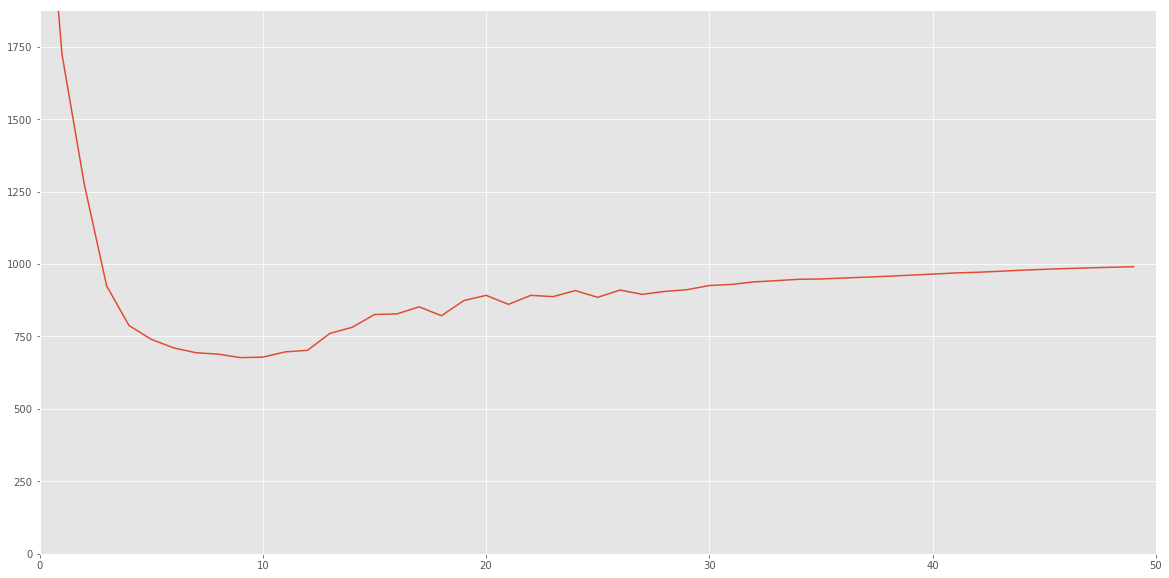

final loss on test set: 990.6167866196483


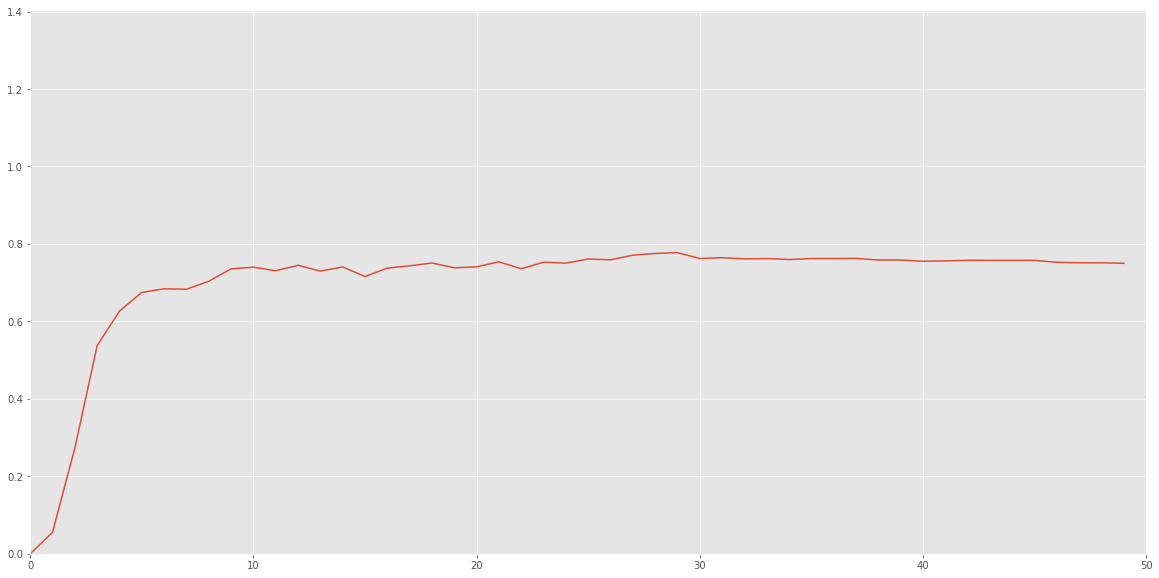

final accuracy on test set: 0.7499161031849652


In [87]:
X_filename = '/home/anna/shallow_syntactic_function_labeller/data/breton/bre-morph.txt'
y_filename = '/home/anna/shallow_syntactic_function_labeller/data/breton/bre-syntax.txt'

train_set, test_set, morph2int, syntax2int, int2syntax, max_length, voc_size = prepare_data(X_filename, 
                                                                                            y_filename)

RNN_BUILDER = dy.LSTMBuilder
EOS = "<EOS>"
VOCAB_SIZE = voc_size
MAX_STRING_LEN = max_length
RNN_NUM_OF_LAYERS = 2
EMBEDDINGS_SIZE = voc_size
STATE_SIZE = 128

rnn = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(rnn, train_set, test_set)

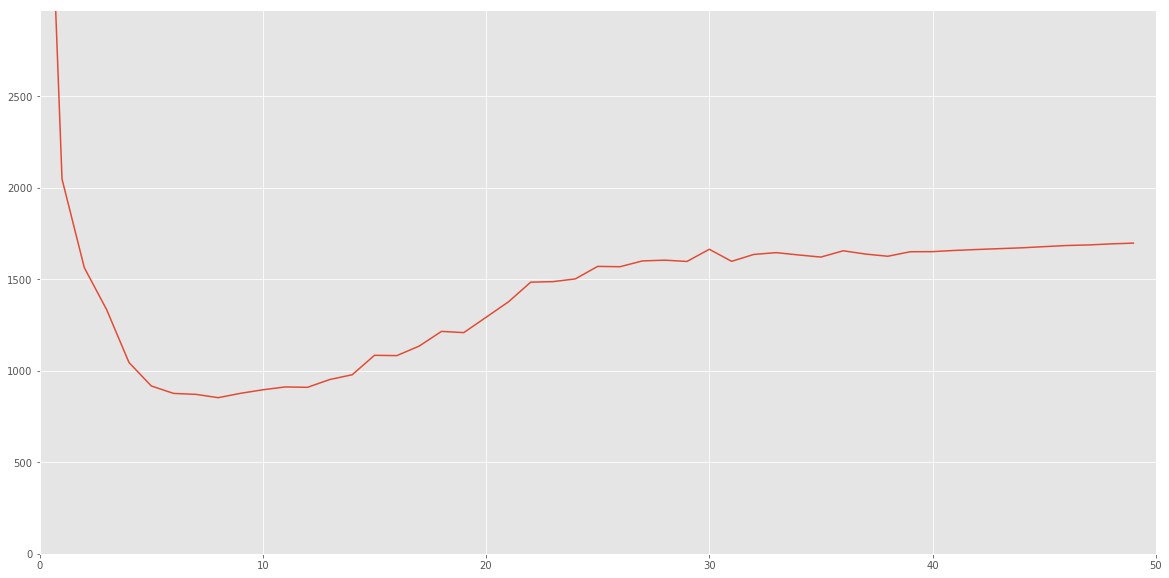

final loss on test set: 1698.2448247658322


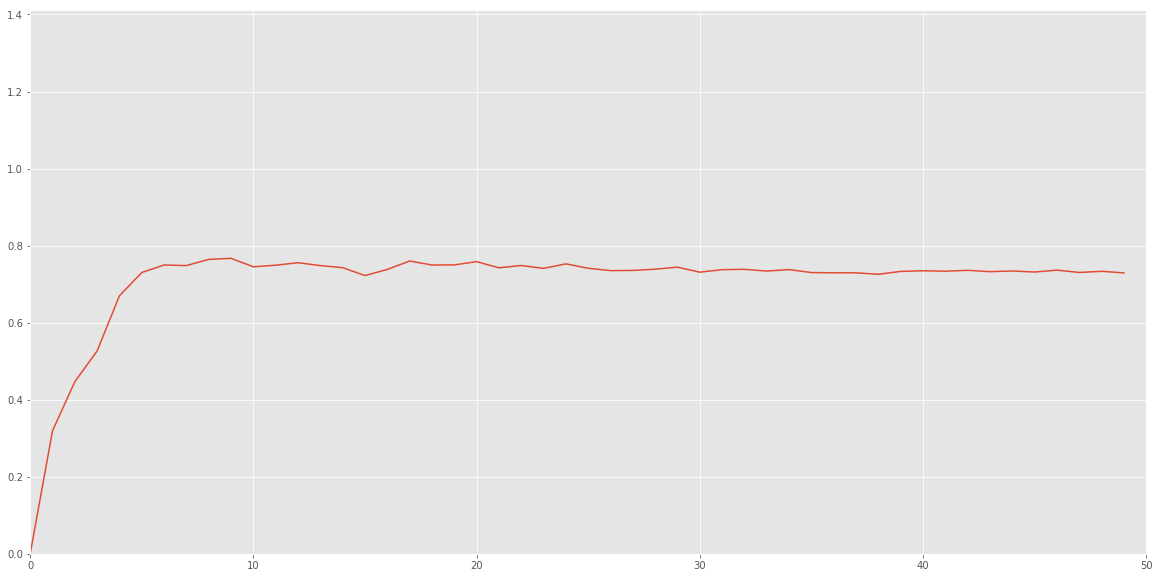

final accuracy on test set: 0.7291770795034332


In [ ]:
X_filename = '/home/anna/shallow_syntactic_function_labeller/data/kazakh/kk-morph.txt'
y_filename = '/home/anna/shallow_syntactic_function_labeller/data/kazakh/kk-syntax.txt'

train_set, test_set, morph2int, syntax2int, int2syntax, max_length, voc_size = prepare_data(X_filename, 
                                                                                            y_filename)

RNN_BUILDER = dy.LSTMBuilder
EOS = "<EOS>"
VOCAB_SIZE = voc_size
MAX_STRING_LEN = max_length
RNN_NUM_OF_LAYERS = 2
EMBEDDINGS_SIZE = voc_size
STATE_SIZE = 128

rnn = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(rnn, train_set, test_set)

In [ ]:
X_filename = '/home/anna/shallow_syntactic_function_labeller/data/sami/sme-morph.txt'
y_filename = '/home/anna/shallow_syntactic_function_labeller/data/sami/sme-syntax.txt'

train_set, test_set, morph2int, syntax2int, int2syntax, max_length, voc_size = prepare_data(X_filename, 
                                                                                            y_filename)

RNN_BUILDER = dy.LSTMBuilder
EOS = "<EOS>"
VOCAB_SIZE = voc_size
MAX_STRING_LEN = max_length
RNN_NUM_OF_LAYERS = 2
EMBEDDINGS_SIZE = voc_size
STATE_SIZE = 128

rnn = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(rnn, train_set, test_set)